In [53]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file\n",
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

In [54]:
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate

In [55]:
justice_dict = {}
justices = ["John G. Roberts, Jr.", "Clarence Thomas", "Samuel A. Alito, Jr.", "Sonia Sotomayor",
            "Elena Kagan", "Neil M. Gorsuch", "Brett M. Kavanaugh", "Amy Coney Barrett", "Ketanji Brown Jackson"]

In [56]:
# This is an LLMChain to define the justice
# llm = OpenAI(temperature=.8)
llm=ChatOpenAI(model_name = "gpt-4", temperature=0)
synopsis_template = """You are Supreme Court Justice {name},. \n
When presented with a legal question, you will respond with a legal opinion based on your interpretation of the law as {name} would.

Question: {question}
Supreme Court Justice: This is my legal opinion on the above question:"""
synopsis_prompt_template = PromptTemplate(input_variables=["name", "question"], template=synopsis_template)
synopsis_chain = LLMChain(llm=llm, prompt=synopsis_prompt_template, output_key="opinion")

In [57]:
# This is an LLMChain to characterize the opinion 
llm = OpenAI(temperature=.2)
template = """You accept take a legal question and legal opinion and interpret the opinion as being 'In Favor', 'Against', or 'Undecided'.

Question: {question}
Legal Opinion: {opinion}
Interpretation of the above opinion:"""

prompt_template = PromptTemplate(input_variables=["question", "opinion"], template=template)
review_chain = LLMChain(llm=llm, prompt=prompt_template, output_key="interpretation")

In [58]:
# This is the overall chain where we run these two chains in sequence.
from langchain.chains import SequentialChain
overall_chain = SequentialChain(
    chains=[synopsis_chain, review_chain], 
    input_variables=["name", "question"],
    # Here we return multiple variables
    output_variables=["opinion", "interpretation"],
    verbose=False)

In [59]:
def encode_output(output):
    mapping = {"In Favor": 1, "Against": -1, "Undecided": 0}
    return mapping.get(output, "Invalid output")

In [60]:
# def make_the_call(justice, iterations):
#     rulings = []
#     for i in range(1, iterations):
#         ruling = overall_chain({"name":justice, "question": "Does the US constitution support the notion that there is a constitutional right to abortion?"})
#         rulings.append(encode_output(ruling['interpretation'].strip()))
#     print(rulings)
#     return [justice, rulings]

In [61]:
import threading

# Initialize a lock
lock = threading.Lock()

def make_the_call(justice, iterations):
    rulings = []
    for i in range(iterations):
        ruling = overall_chain({"name":justice, "question": "Does the US constitution support the notion that there is a constitutional right to abortion?"})
        rulings.append(encode_output(ruling['interpretation'].strip()))
    return [justice, rulings]

In [62]:
def worker(justice, counts):
    rulings = make_the_call(justice, 6)
    with lock:  # Ensure thread-safe update of counts
        counts[justice] = {ruling: rulings[1].count(ruling) for ruling in [0, 1, -1]}  # Count from rulings[1]

In [63]:
counts = {}
threads = []

for justice in justices:
    print(f"starting thread: {justice}")    
    thread = threading.Thread(target=worker, args=(justice, counts))
    thread.start()
    threads.append(thread)

# Wait for all threads to complete
for thread in threads:
    thread.join()

starting thread: John G. Roberts, Jr.
starting thread: Clarence Thomas
starting thread: Samuel A. Alito, Jr.
starting thread: Sonia Sotomayor
starting thread: Elena Kagan
starting thread: Neil M. Gorsuch
starting thread: Brett M. Kavanaugh
starting thread: Amy Coney Barrett
starting thread: Ketanji Brown Jackson


In [64]:
# # Initialize a Counter for each category
# counts = {0: [], 1: [], -1: []}

# # Get the counts for each justice
# for justice in justices:
#     rulings = make_the_call(justice, 12)
#     for ruling in [0, 1, -1]:
#         counts[ruling].append(rulings[1].count(ruling))  # Count from rulings[1]

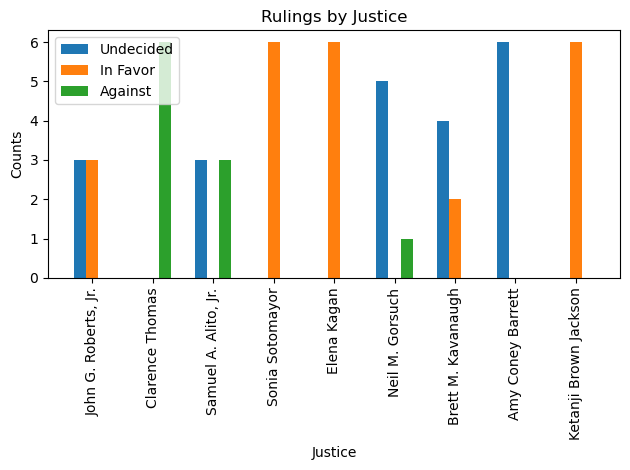

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the plot
x = np.arange(len(justices))
width = 0.2

fig, ax = plt.subplots()

# Adjust the data format for plotting
undecided = [counts[justice][0] for justice in justices]
in_favor = [counts[justice][1] for justice in justices]
against = [counts[justice][-1] for justice in justices]

rects1 = ax.bar(x - width, undecided, width, label='Undecided')
rects2 = ax.bar(x, in_favor, width, label='In Favor')
rects3 = ax.bar(x + width, against, width, label='Against')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Justice')
ax.set_ylabel('Counts')
ax.set_title('Rulings by Justice')
ax.set_xticks(x)
ax.set_xticklabels(justices, rotation=90)
ax.legend()

fig.tight_layout()
plt.show()